### Regge-Wheeler-Zerilli Evolution | Adaptive Characteristic Method
**Author**: Ken Sible | **Date**: July 22, 2019

<img src="images/adaptive_figure.png" width="2236" height="1258" align="center"/>

**Adaptive Characteristic Method Algorithm**

\begin{align}
    \text{Lower Resolution: }&\psi^{(LR)}\,(n\rightarrow n+1)\\
    \text{Higher Resolution, 1: }&\psi^{(HR,1)}\,(n\rightarrow n+1/2)\\
    \text{Higher Resolution, 2: }&\psi^{(HR,2)}\,(n+1/2\rightarrow n+1)
\end{align}
~~~~
# Define Constants, Functions, and Initial Conditions
while u[n] < u_max
    # Compute ψLR, ψHR[1], ψHR[2]
    ε = maximum(abs.(ψHR[2] - ψLR))
    if ε < tol
        push(ψ, ψLR)
        push(u, u[n] + du)
        n += 1
    end
    du *= (tol/ε)^(1/2)
end
~~~~

In [1]:
include("packages/NumericDE.jl")
using PyPlot, Main.NumericDE

""" lambertw(z, [tol])

    Solves z = w * exp(w) for w using the Newton-Raphson method
    with the specified tolerance, assuming the principle branch.
"""
function lambertw(z::Number; tol::Real=1e-8)
    z < -1/ℯ && throw(DomainError())
    f(w) = w * exp(w) - z
    df(w) = exp(w) * (w + 1)
    w = z < 1 ? z : log(z)
    f(w) == 0 && return w
    begin i = 0
        while abs(f(w)) > tol
            w += -f(w)/df(w)
            (i += 1) > 1000 && break
        end
    end
    return w
end;

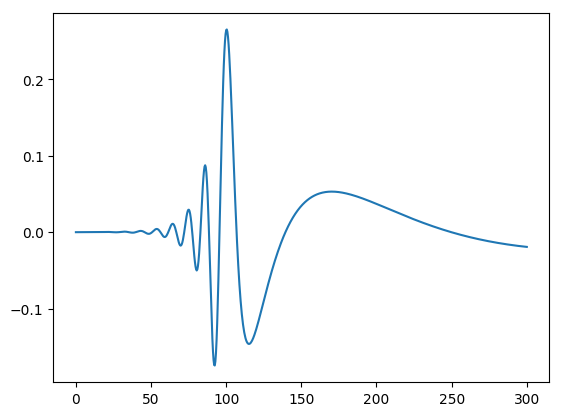

In [2]:
hx, ht, hu, hv = 0.2, 0.04, 0.4, 0.4
x0, x = 200, collect(-250:hx:250)
(ui, uf), (vi, vf) = (0, 300), (0, 300)

ψIS, ψFS = Float64[], Float64[]
function RK4_UV(t::Real, y::Array{<:Real}, f::Function, h::Real, args...)
    p = [0, 1/2, 1/2, 1]
    q = [0 0 0 0; 1/2 0 0 0; 0 1/2 0 0; 0 0 1 0]
    a = [1/6, 1/3, 1/3, 1/6]
    
    k1 = f(t, y, args...)
    k2 = f(t + p[2]*h, y + h*(q[2, 1]*k1), args...)
    k3 = f(t + p[3]*h, y + h*(q[3, 1]*k1 + q[3, 2]*k2), args...)
    k4 = f(t + p[4]*h, y + h*(q[4, 1]*k1 + q[4, 2]*k2 + q[4, 3]*k3), args...)
    
    y += h*(a[1]*k1 + a[2]*k2 + a[3]*k3 + a[4]*k4); t = round(t + h, digits=2)
    
    for j = 1:length(x)
        u, v = t - x[j], t + x[j]

        if (vi <= v <= vf) && u == ui
            push!(ψIS, y[j, 1])
        end
        if (ui <= u <= uf) && v == vf
            push!(ψFS, y[j, 1])
        end
    end
    return y
end

l, r_s = 3, 2 # Angular Momentum, Schwarzschild Radius
V(r) = (1 - r_s/r)*((l + 1)l/r^2 - 3r_s/r^3)
r(x) = 2(lambertw(exp((x - 2)/2)) + 1)
U = V.(r.(x)) # Vectorized Potential

function f(t, ψ)
    Nx = size(ψ)[1]
    ψxx = zeros(Nx)
    for j = 2:(Nx - 1)
        ψxx[j] = (ψ[j + 1, 1] - 2ψ[j, 1] + ψ[j - 1, 1])/hx^2
    end
    return hcat(ψ[:, 2], ψxx .- U .* ψ[:, 1])
end

g(x) = 0.5(exp(-0.1(x - x0)^2))
∂t_g(x) = 2*0.1(x0 - x) * g.(x)
ψ0 = hcat(g.(x), ∂t_g.(x))

pdeint(f, (0, 300), (-250, 250), ψ0, ht, hx, method=RK4_UV);
plot(ui:hu:uf, ψFS[end:-1:1]);

In [ ]:
function uv_wavefunc(uspan::NTuple{2, Real}, vspan::NTuple{2, Real},
        du::Real, dv::Real, ψ0::Vector{<:Real})
    (ui, uf), (vi, vf) = uspan, vspan
    u, v = ui:du:uf, vi:dv:vf
    Nu, Nv = length(u), length(v)
    
    l, r_s = 3, 2 # Angular Momentum, Schwarzschild Radius
    V(r) = (1 - r_s/r)*((l + 1)l/r^2 - 3r_s/r^3)
    r(x) = 2(lambertw(exp((x - 2)/2)) + 1)

    ψ = zeros(Nv, Nu); ψ[:, 1] = ψ0
    
    for n = 1:(Nv - 1), k = 1:(Nu - 1)
        x = ((v[n] - u[k + 1]) + (v[n + 1] - u[k]))/4
        α = 1 - (du * dv)/8 * V(r(x)) # du/150
        ψ[n + 1, k + 1] = α * (ψ[n + 1, k] + ψ[n, k + 1]) - ψ[n, k]
    end

    return ψ, u, v
end

function uv_adaptive(uspan::NTuple{2, Real}, vspan::NTuple{2, Real},
        du::Real, dv::Real, ψ0::Function; tol=1e-6, dv_max=100)
    (ui, uf), (vi, vf) = uspan, vspan
    u = ui:du:uf; Nu = length(u)
    
    l, r_s = 3, 2 # Angular Momentum, Schwarzschild Radius
    V(r) = (1 - r_s/r)*((l + 1)l/r^2 - 3r_s/r^3)
    r(x) = 2(lambertw(exp((x - 2)/2)) + 1)

    n, v = 1, Float64[vi]
    ψ = zeros(1, Nu); ψ[1, 1] = ψ0(v[1])
    ψLR, ψHR = zeros(Nu), zeros(2, Nu)

    while v[n] < vf
        ψLR[1] = ψHR[1, 1] = ψHR[2, 1] = ψ0(v[n])
        for k = 1:(Nu - 1)
            x = ((v[n] - u[k + 1]) + ((v[n] + dv) - u[k]))/4
            α = 1 - (du * dv)/8 * V(r(x))
            ψLR[k + 1] = α * (ψLR[k] + ψ[n, k + 1]) - ψ[n, k]

            x = ((v[n] - u[k + 1]) + ((v[n] + dv/2) - u[k]))/4
            α = 1 - (du * dv/2)/8 * V(r(x))
            ψHR[1, k + 1] = α * (ψHR[1, k] + ψ[n, k + 1]) - ψ[n, k]

            x = (((v[n] + dv/2) - u[k + 1]) + ((v[n] + dv) - u[k]))/4
            α = 1 - (du * dv/2)/8 * V(r(x))
            ψHR[2, k + 1] = α * (ψHR[2, k] + ψHR[1, k + 1]) - ψHR[1, k]
        end
        ϵ = maximum(abs.(ψHR[2, :] - ψLR))
        if ϵ < tol
            ψ = [ψ; ψLR']
            push!(v, v[n] + dv)
            n += 1
        end
        dv = (dv * (tol/ϵ)^(1/2)) > dv_max ?
            dv_max : dv * (tol/ϵ)^(1/2)
        if v[n] > vf
            ψ = ψ[1:(end - 1), :]
            v = v[1:(end - 1)]
            dv, n = vf - v[end], n - 1
        end
    end

    return ψ, u, v
end;

In [ ]:
hu_HR, hv_HR = _______ # High Resolution (Approximate 'Exact' Solution)
(ui, uf), (vi, vf) = (0, x0 + _______), (0, x0 + _______)
x0 = _______; ψIS = g.(vi:hv:vf) # Boundary Condition (Gaussian Approximation)
ψUV_HR, u_HR, v_HR = uv_wavefunc((ui, uf), (vi, vf), hu_HR, hv_HR, ψIS)

In [ ]:
ψ0 = hcat(g.(x), ∂t_g.(x))
ψIS, ψFS = Float64[], Float64[]
@time pdeint(f, (0, x0 + _______), (-(x0 + _______), x0 + _______), ψ0, ht, hx, method=RK4_UV)
const error = norm(ψFS .- ψUV_HR)

In [ ]:
@time ψUV, u, v = uv_adaptive((ui, uf), (vi, vf), hu, hv, g, tol=error)
@assert error - _______ <= norm(ψUV .- ψUV_HR) <= error + _______

In [ ]:
# Plot Computational Time vs Final Characteristic Distance
# Move Final Characteritic Further and Repeat Process

In [ ]:
using Hilbert

row_vector(x::Vector) = reshape(x, 1, length(x))
(ui, uf), (vi, vf) = (0, _______), (0, _______)
ψIS = g.(vi:hv:vf)
ψUV, u, v = uv_adaptive((ui, uf), (vi, vf), hu, hv, ψIS)

ψ = row_vector(ψUV[_______, :])
plot(u, abs.(hilbert(ψ))'); # TODO: Log Plot?
plot(u, -abs.(hilbert(ψ))'); plot(u, ψ');